In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys
import os





In [2]:
sys.path.append(os.path.abspath('scripts'))

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')


try:
    from risk_utils import (
        load_and_preprocess_data,
        create_advanced_wallet_features,
        calculate_advanced_risk_score,
        apply_ml_refinements,
        calculate_final_risk_score
    )
except ImportError:
    print("FATAL ERROR: Could not import from 'risk_utils.py'.")
    print("Please ensure 'scripts/risk_utils.py' exists in your project directory.")
   
    wallet_df = None

### Generate Data for Visualization by Running the Pipeline

In [3]:
def generate_visualization_data(filepath='data/compound_v2_v3_transactions.csv'):
    
    print("Generating data for visualization...")
    
    df_processed = load_and_preprocess_data(filepath)
    if df_processed is None or df_processed.empty:
        return None
    
    wallet_df = create_advanced_wallet_features(df_processed)
    wallet_df = wallet_df.fillna(0)
    
   
    wallet_df['base_risk_score'] = calculate_advanced_risk_score(wallet_df)
    
   
    wallet_df = apply_ml_refinements(wallet_df)
    

    wallet_df['final_risk_score'] = calculate_final_risk_score(wallet_df)
    
    def categorize_risk(score):
        if score < 200: return 'Very Low'
        elif score < 400: return 'Low'
        elif score < 600: return 'Medium'
        elif score < 800: return 'High'
        else: return 'Very High'
    wallet_df['risk_category'] = wallet_df['final_risk_score'].apply(categorize_risk)
    
    print("...Data successfully generated.")
    return wallet_df

if 'load_and_preprocess_data' in locals():
    wallet_df = generate_visualization_data()
else:
    wallet_df = None

Generating data for visualization...
Successfully loaded data/compound_v2_v3_transactions.csv
Processing features for 80 wallets using 'wallet_address' as identifier...
...feature engineering complete.
Calculating advanced risk scores...
...base risk score calculation complete.
Applying ML refinements (Anomaly Detection and Clustering)...
...identified 4 anomalous wallets.
...clustered wallets into 5 groups.
...Data successfully generated.


### Distribution of Final Risk Scores

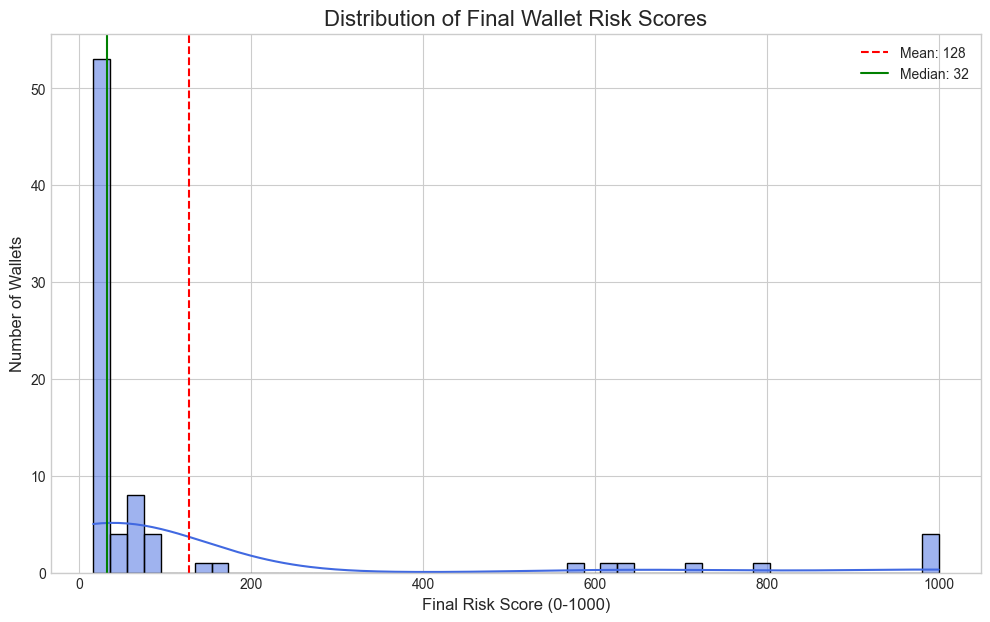

In [4]:

if wallet_df is not None:
    plt.figure(figsize=(12, 7))
    sns.histplot(wallet_df['final_risk_score'], bins=50, kde=True, color='royalblue')
    plt.title('Distribution of Final Wallet Risk Scores', fontsize=16)
    plt.xlabel('Final Risk Score (0-1000)', fontsize=12)
    plt.ylabel('Number of Wallets', fontsize=12)
    plt.axvline(wallet_df['final_risk_score'].mean(), color='red', linestyle='--', label=f"Mean: {wallet_df['final_risk_score'].mean():.0f}")
    plt.axvline(wallet_df['final_risk_score'].median(), color='green', linestyle='-', label=f"Median: {wallet_df['final_risk_score'].median():.0f}")
    plt.legend()
    plt.show()
else:
    print("Cannot generate plots because data generation failed.")

### Risk Category Breakdown

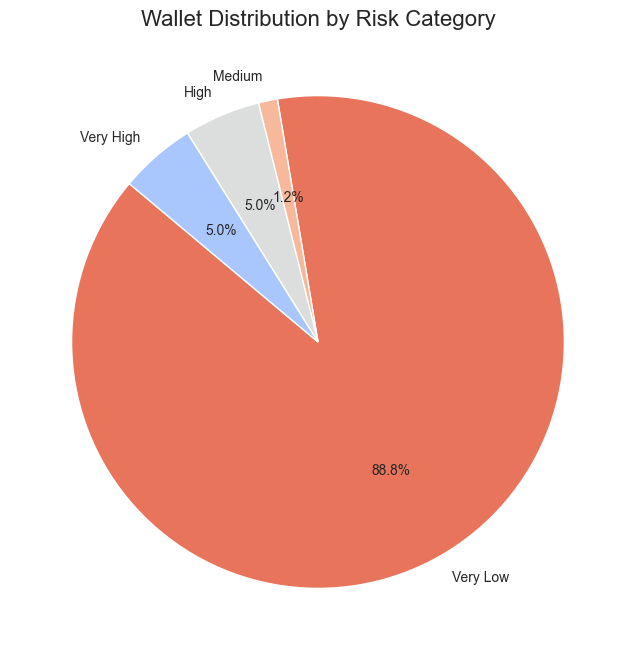

In [5]:

if wallet_df is not None:
    plt.figure(figsize=(10, 8))
    category_order = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
    category_counts = wallet_df['risk_category'].value_counts().reindex(category_order)
    
    colors = sns.color_palette('coolwarm_r', n_colors=5)
    plt.pie(category_counts.dropna(), labels=category_counts.dropna().index, autopct='%1.1f%%', startangle=140, colors=colors,
            wedgeprops={'edgecolor': 'white'})
    plt.title('Wallet Distribution by Risk Category', fontsize=16)
    plt.ylabel('') # Hide the y-label for pie charts
    plt.show()

### Feature Importance Analysis

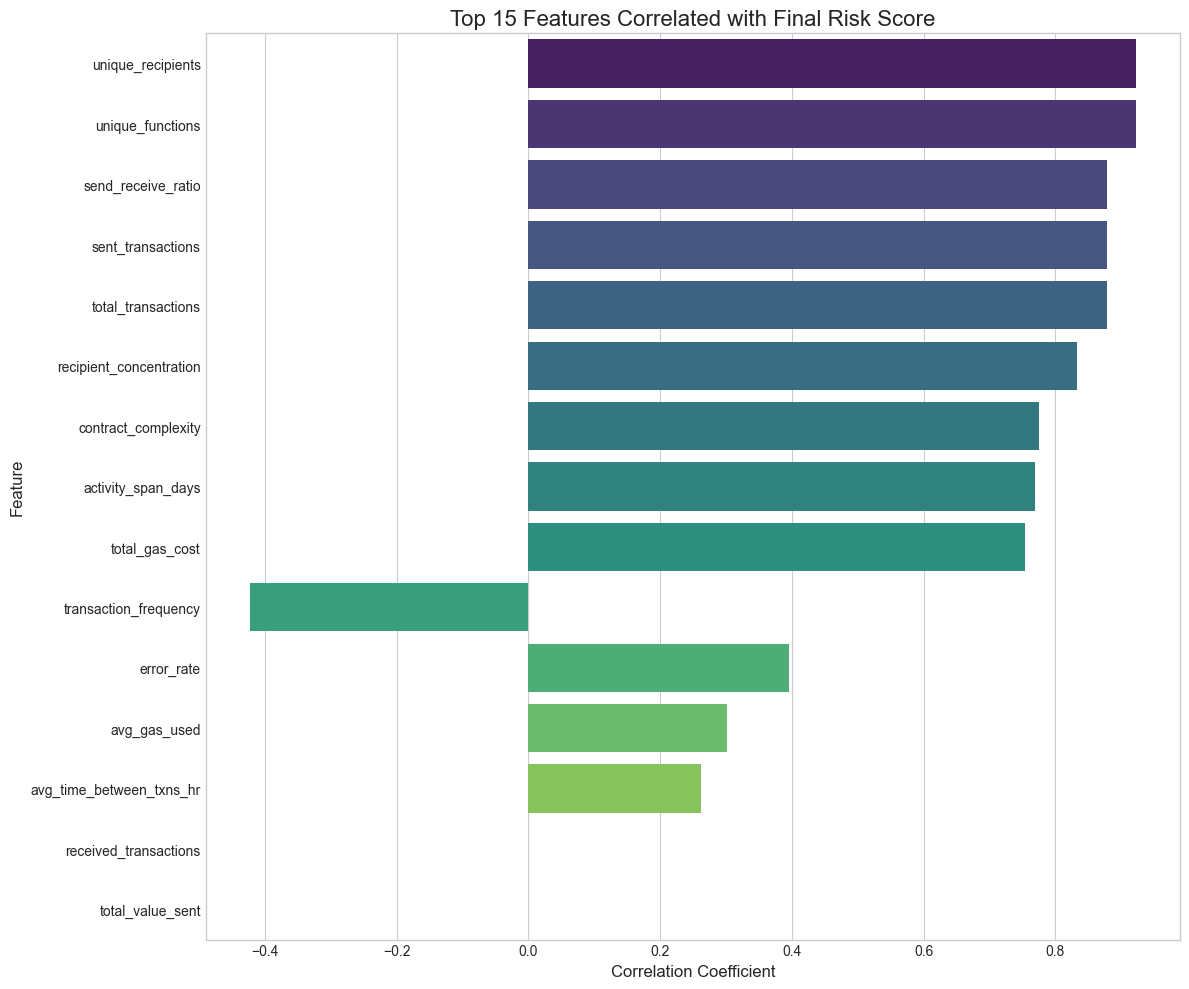

In [6]:

if wallet_df is not None:
    feature_cols_analysis = [col for col in wallet_df.columns if col not in [
        'wallet_id', 'base_risk_score', 'final_risk_score', 'anomaly_score',
        'is_anomaly', 'cluster', 'cluster_risk_adjustment', 'risk_category'
    ]]

 
    if feature_cols_analysis:
        feature_importance = pd.DataFrame({
            'feature': feature_cols_analysis,
            'correlation_with_risk': [wallet_df[col].corr(wallet_df['final_risk_score']) for col in feature_cols_analysis]
        }).sort_values('correlation_with_risk', key=abs, ascending=False).head(15)

        plt.figure(figsize=(12, 10))
        sns.barplot(x='correlation_with_risk', y='feature', data=feature_importance, palette='viridis')
        plt.title('Top 15 Features Correlated with Final Risk Score', fontsize=16)
        plt.xlabel('Correlation Coefficient', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        plt.tight_layout()
        plt.show()

### Cluster Analysis


Analyzing cluster characteristics...


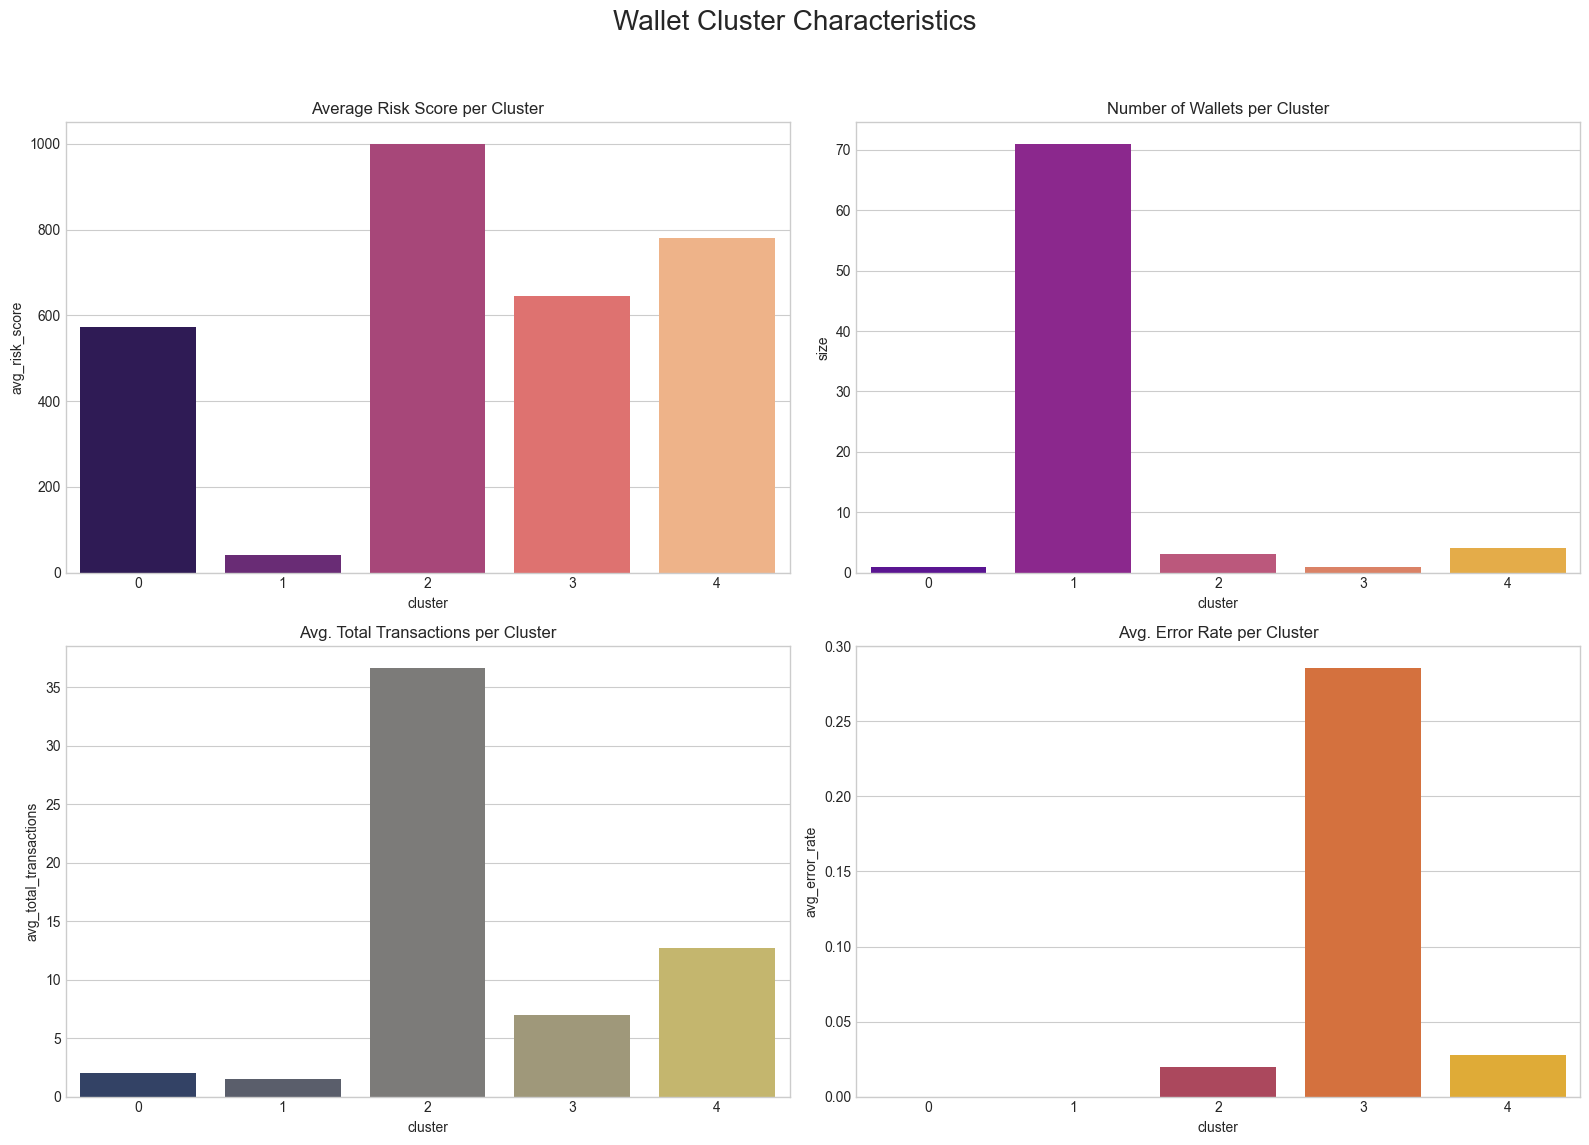

In [7]:
if wallet_df is not None:
    print("\nAnalyzing cluster characteristics...")
    cluster_summary = wallet_df.groupby('cluster').agg(
        avg_risk_score=('final_risk_score', 'mean'),
        avg_total_transactions=('total_transactions', 'mean'),
        avg_error_rate=('error_rate', 'mean'),
        avg_tx_frequency=('transaction_frequency', 'mean'),
        size=('wallet_id', 'count')
    ).reset_index()

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Wallet Cluster Characteristics', fontsize=20)
    
    sns.barplot(ax=axes[0, 0], x='cluster', y='avg_risk_score', data=cluster_summary, palette='magma')
    axes[0, 0].set_title('Average Risk Score per Cluster')

    sns.barplot(ax=axes[0, 1], x='cluster', y='size', data=cluster_summary, palette='plasma')
    axes[0, 1].set_title('Number of Wallets per Cluster')

    sns.barplot(ax=axes[1, 0], x='cluster', y='avg_total_transactions', data=cluster_summary, palette='cividis')
    axes[1, 0].set_title('Avg. Total Transactions per Cluster')

    sns.barplot(ax=axes[1, 1], x='cluster', y='avg_error_rate', data=cluster_summary, palette='inferno')
    axes[1, 1].set_title('Avg. Error Rate per Cluster')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()